In [32]:
# process images
import os
import cv2
import torch
from tqdm import tqdm

base_path = "/home/ramanuja-simha/Downloads/28050083/TCGA-BRCA-A2-DEEPMED-TILES/BLOCKS_NORM_MACENKO/"  
image_size = (256, 256)  
max_patches_per_patient = 100
mean = [0.485, 0.456, 0.406]  
std = [0.229, 0.224, 0.225]   
all_patient_data_image = {}
patient_folders = os.listdir(base_path)

for patient in tqdm(patient_folders, desc="Processing Patients"):
    patient_path = os.path.join(base_path, patient)
    patient = patient.split("-")[:3]
    patient = "-".join(patient)
    patient += "-01"
    if not os.path.isdir(patient_path):
        continue
    processed_slices = []
    slice_files = os.listdir(patient_path)
    for slice_file in slice_files[:max_patches_per_patient]:
        slice_path = os.path.join(patient_path, slice_file)
        try:
            img = cv2.imread(slice_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_resized = cv2.resize(img_rgb, image_size)
            img_normalized = img_resized / 255.0
            img_normalized = (img_normalized - mean) / std
            img_tensor = \
                torch.tensor(img_normalized, \
                        dtype=torch.float32).permute(2, 0, 1)
            # img_uint8 = \
            #     (img_tensor * 255).byte().permute(1, 2, 0).numpy()  
            # gray_image = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2GRAY) 
            # _, segmented_image = \
            #         cv2.threshold(gray_image, \
            #                 127, 255, cv2.THRESH_BINARY)
            # segmented_image_tensor = \
            #     torch.tensor(segmented_image, \
            #                  dtype=torch.float32).unsqueeze(0) 
            # img_tensor = segmented_image_tensor.repeat(3, 1, 1)
            processed_slices.append(img_tensor)
            break
        except Exception as e:
            print(f"Error processing {slice_path}: {e}")
            continue
    if processed_slices:
        all_patient_data_image[patient] = \
            torch.stack(processed_slices)  
print("patients:",len(all_patient_data_image))
print("patient:",next(iter(all_patient_data_image.keys())))
print("image features:",all_patient_data_image[ next(iter(all_patient_data_image.keys()))].shape)

Processing Patients: 100%|███████████████████| 100/100 [00:00<00:00, 246.06it/s]

patients: 100
patient: TCGA-A2-A0ER-01
image features: torch.Size([1, 3, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357142857142856..2.6399999999999997].


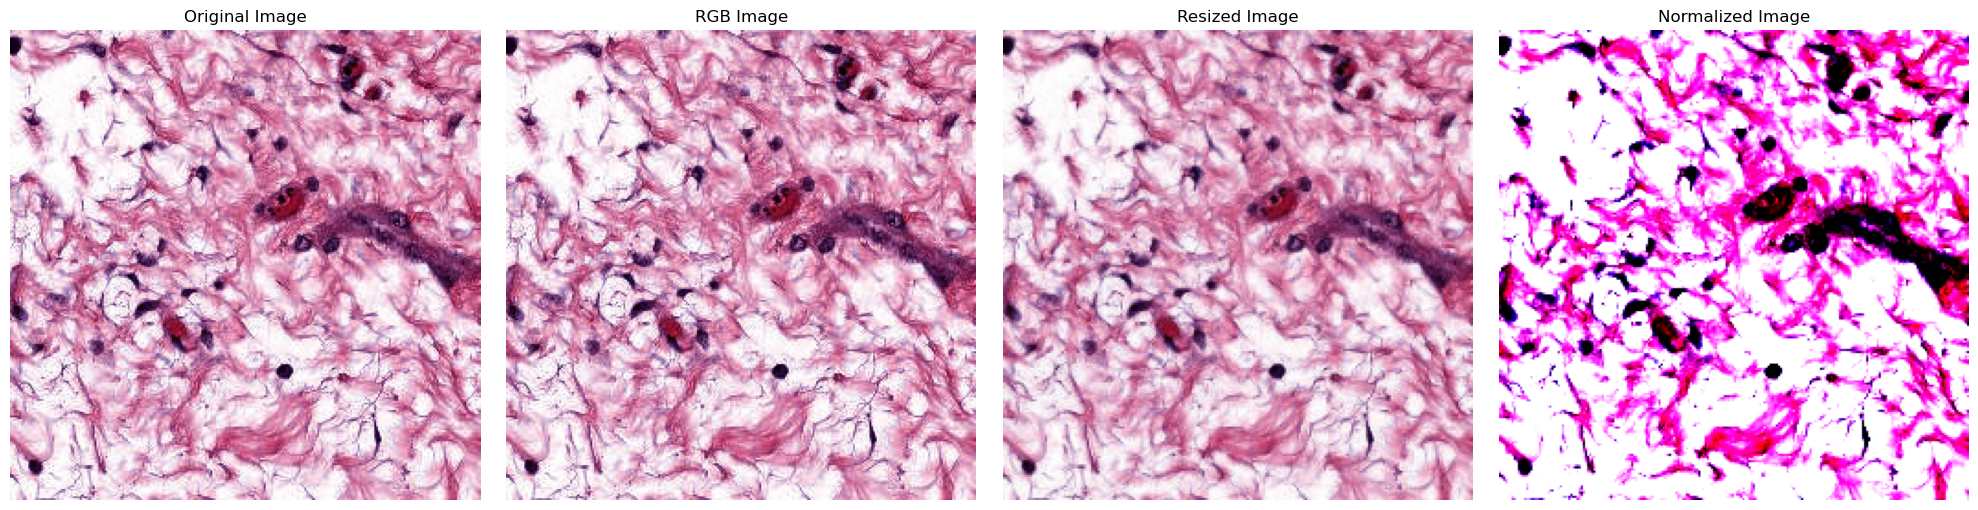

In [33]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

# normalize in a way consistent w/ pretrained models like ImageNet
image_size = (224, 224)  
mean = np.array([0.485, 0.456, 0.406])  
std = np.array([0.229, 0.224, 0.225])  

def preprocess_and_plot(slice_path):
    img = cv2.imread(slice_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, image_size)
    img_normalized = img_resized / 255.0
    img_normalized = (img_normalized - mean) / std
    img_tensor = \
        torch.tensor(img_normalized, \
                dtype=torch.float32).permute(2, 0, 1)

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    axes[1].imshow(img_rgb)
    axes[1].set_title("RGB Image")
    axes[1].axis('off')
    axes[2].imshow(img_resized)
    axes[2].set_title("Resized Image")
    axes[2].axis('off')
    axes[3].imshow(img_normalized)
    axes[3].set_title("Normalized Image")
    axes[3].axis('off')
    plt.tight_layout()
    plt.show()
    return img_tensor

slice_path = "/home/ramanuja-simha/Downloads/28050083/TCGA-BRCA-A2-DEEPMED-TILES/BLOCKS_NORM_MACENKO/TCGA-A2-A4S3-01Z-00-DX1.50699E65-E536-4C9B-93A7-4C9894624A29/TCGA-A2-A4S3-01Z-00-DX1.50699E65-E536-4C9B-93A7-4C9894624A29_(9342,58128).jpg"
img_tensor = preprocess_and_plot(slice_path)

torch.Size([1, 224, 224])


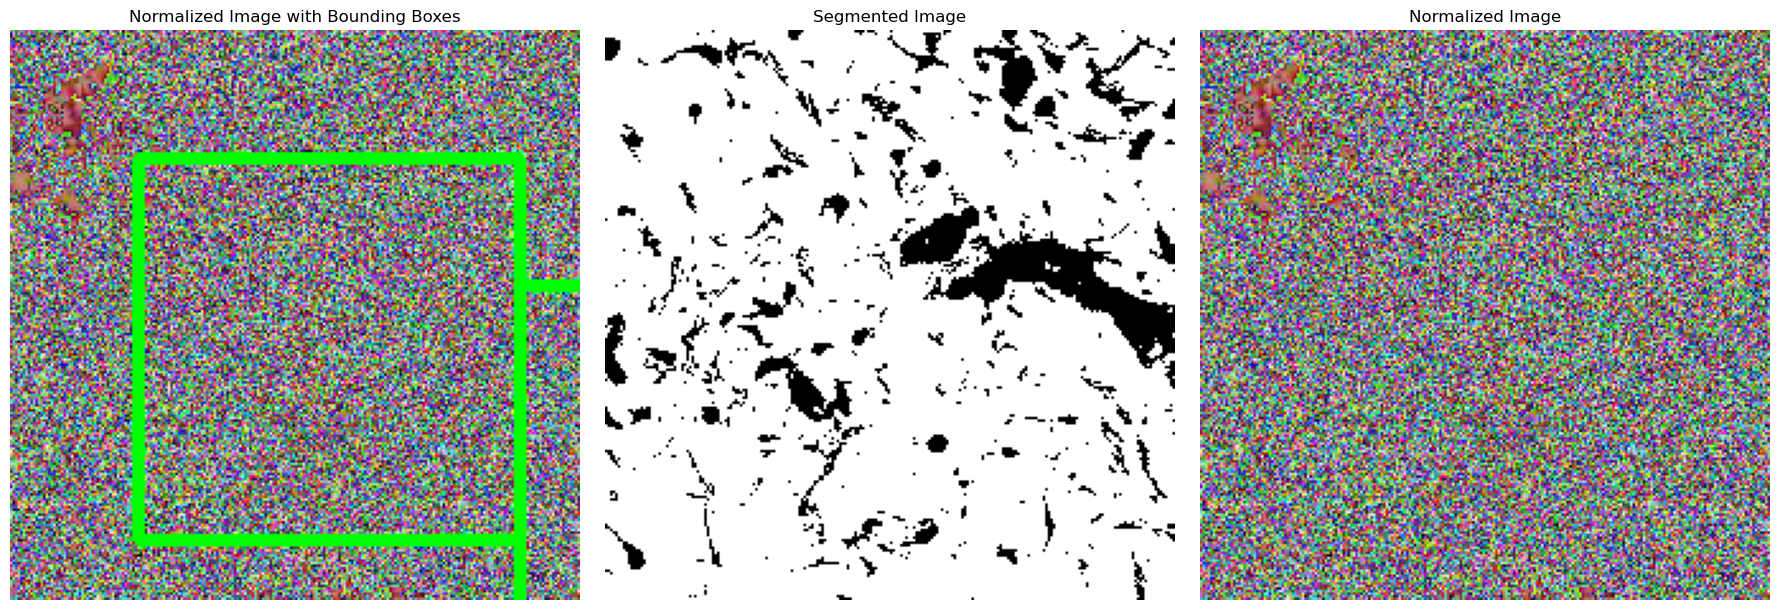

In [34]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
import numpy as np

def preprocess_and_segment(img_tensor, mean, std):
    img = img_tensor.permute(1, 2, 0).cpu().numpy()  
    img = img * 255.0  
    img = (img - mean) / std  
    img_normalized_tensor = \
        torch.tensor(img, \
            dtype=torch.float32).permute(2, 0, 1)  
    gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  
    _, segmented_image = \
        cv2.threshold(gray_image, 127, 255, \
                      cv2.THRESH_BINARY) 
    segmented_image_tensor = \
        torch.tensor(segmented_image, \
                dtype=torch.float32).unsqueeze(0) 
    print(segmented_image_tensor.shape)
    bounding_boxes = \
            [(50, 50, 150, 150), (200, 100, 350, 250)]  
    img_with_bboxes = img.copy()  
    for (x, y, w, h) in bounding_boxes:
        cv2.rectangle(img_with_bboxes, \
            (x, y), (x + w, y + h), (0, 255, 0), 3)  
    img_with_bboxes_tensor = \
        torch.tensor(img_with_bboxes, \
            dtype=torch.float32).permute(2, 0, 1) 
    return img_with_bboxes_tensor, \
            segmented_image_tensor, img_normalized_tensor

mean = 0.485
std = 0.229
img_with_bboxes_tensor, segmented_image_tensor, \
        img_normalized_tensor = preprocess_and_segment(
                                        img_tensor, mean, std)
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(img_with_bboxes_tensor.permute(1, 2, 0).cpu().numpy().astype(np.uint8)) 
ax[0].set_title("Normalized Image with Bounding Boxes")
ax[0].axis('off')
ax[1].imshow(segmented_image_tensor.squeeze(0).cpu().numpy(), cmap='gray') 
ax[1].set_title("Segmented Image")
ax[1].axis('off')
ax[2].imshow(img_normalized_tensor.permute(1, 2, 0).cpu().numpy().astype(np.uint8))  
ax[2].set_title("Normalized Image")
ax[2].axis('off')
plt.tight_layout()
plt.show()

In [35]:
# process gene expr profiling
import pandas as pd
from sklearn.impute import KNNImputer
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
import numpy as np

file_path = "/home/ramanuja-simha/Downloads/28050083/TCGA-BRCA-RNA-Seq.csv"
gene_expression_df = pd.read_csv( \
    file_path, sep="\t", header=0, index_col=0)  
print("gene expr:",gene_expression_df.shape)
patient_ids = list(all_patient_data_image.keys())
print("patient ids:",len(patient_ids))
filtered_gene_expression_df = \
        gene_expression_df[patient_ids]
transposed_df = filtered_gene_expression_df.T
print("filter:",transposed_df.shape)

row_ids = transposed_df.index.tolist()
imputer = KNNImputer(n_neighbors=5)
gene_data_imputed = \
    imputer.fit_transform(transposed_df)
print("imputer:",gene_data_imputed.shape)
scaler = StandardScaler()
gene_data_normalized = \
    scaler.fit_transform(gene_data_imputed)
print("scaler:",gene_data_normalized.shape)
selector = VarianceThreshold(threshold=0.01)
gene_data_selected = \
    selector.fit_transform(gene_data_normalized)
print("selector:",gene_data_selected.shape)
pca = PCA(n_components=90)
gene_data_reduced = \
    pca.fit_transform(gene_data_selected)
print("pca:",gene_data_reduced.shape)
gene_data_reduced = \
    pd.DataFrame(gene_data_reduced, index=row_ids)

all_patient_data_geneexpr = \
    gene_data_reduced.to_dict(orient='index')
all_patient_data_geneexpr = \
    {patient_id: np.array(list(features_dict.values())) \
        for patient_id, features_dict \
             in all_patient_data_geneexpr.items()}

print("patients:",len(all_patient_data_geneexpr))
print("patient:",next(iter(all_patient_data_geneexpr.keys())))
print("gene expr features:",len(all_patient_data_geneexpr[next(iter(all_patient_data_geneexpr.keys()))]))

gene expr: (20530, 1218)
patient ids: 100
filter: (100, 20530)
imputer: (100, 20530)
scaler: (100, 20530)
selector: (100, 19997)
pca: (100, 90)
patients: 100
patient: TCGA-A2-A0ER-01
gene expr features: 90


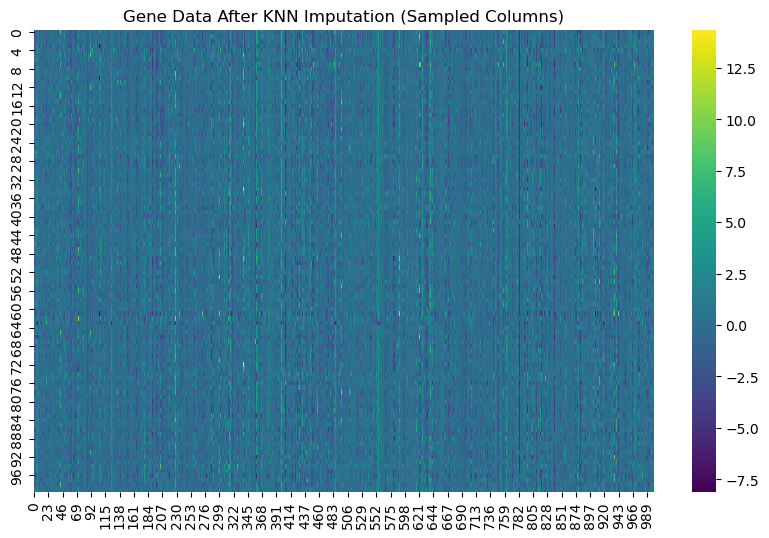

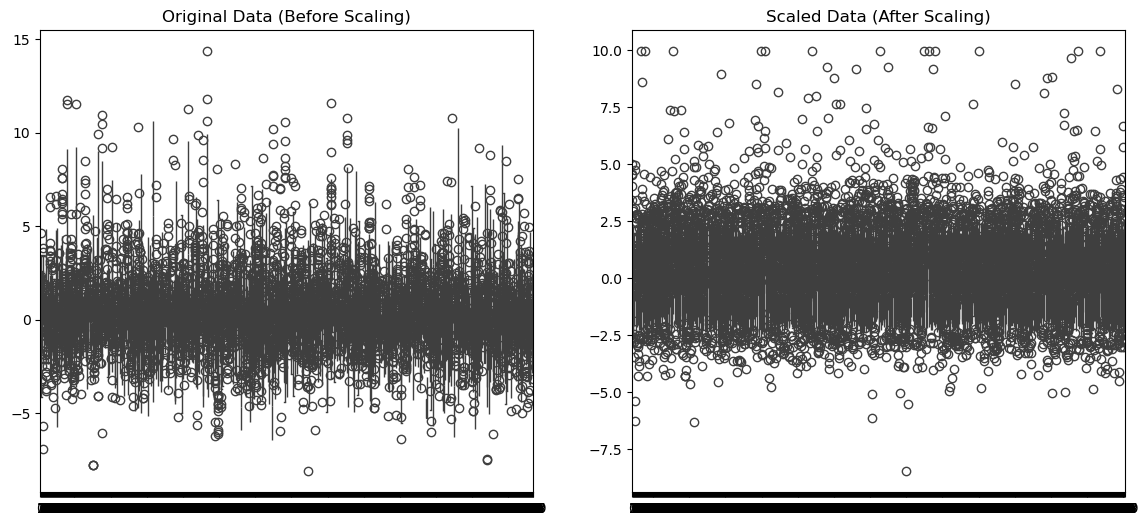

Number of features before selection: 1000
Number of features after selection: 977
Features removed during selection: 23


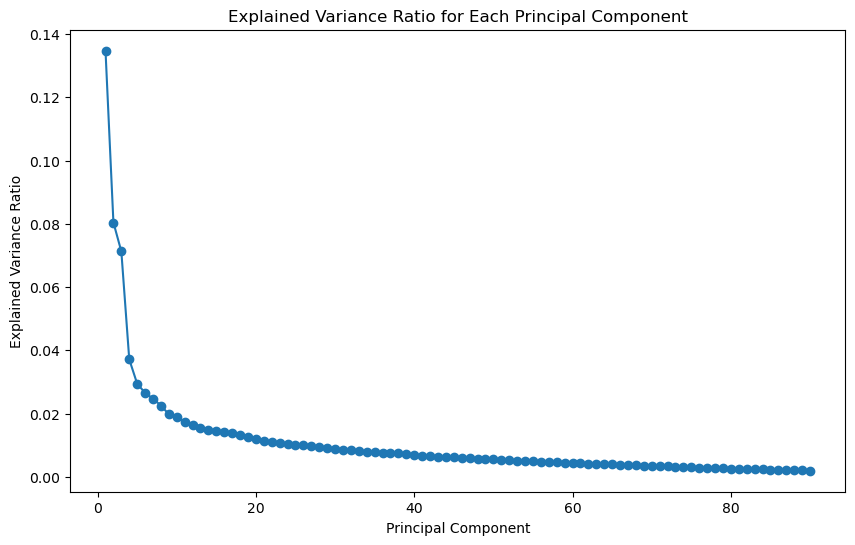

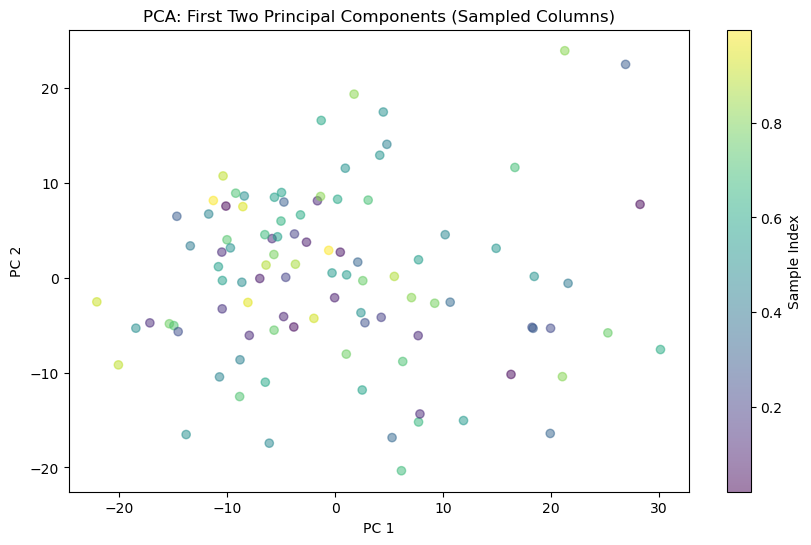

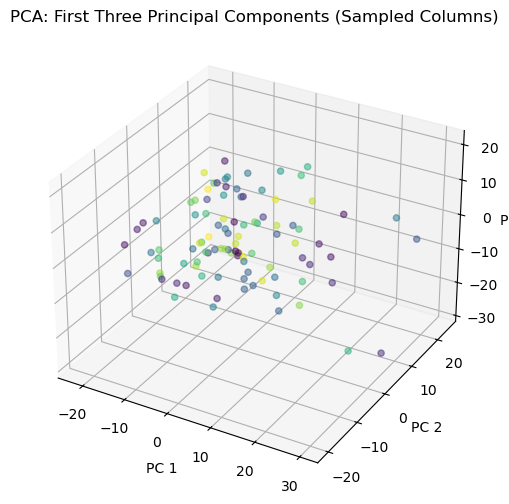

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

sample_size = 1000  
max_sample_size = min(transposed_df.shape[1], 1000)  
sampled_columns = transposed_df.sample( \
    n=max_sample_size, axis=1, random_state=42)
imputer = KNNImputer(n_neighbors=5)
gene_data_imputed = imputer.fit_transform(sampled_columns)
plt.figure(figsize=(10, 6))
sns.heatmap(gene_data_imputed, cmap="viridis", cbar=True)
plt.title("Gene Data After KNN Imputation (Sampled Columns)")
plt.show()  

scaler = StandardScaler()
gene_data_normalized = scaler.fit_transform(gene_data_imputed)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.boxplot(data=gene_data_imputed, ax=axes[0])
axes[0].set_title("Original Data (Before Scaling)")
sns.boxplot(data=gene_data_normalized, ax=axes[1])
axes[1].set_title("Scaled Data (After Scaling)")
plt.show() 

selector = VarianceThreshold(threshold=0.01)
gene_data_selected = selector.fit_transform(gene_data_normalized)
print(f"Number of features before selection: {gene_data_normalized.shape[1]}")
print(f"Number of features after selection: {gene_data_selected.shape[1]}")
feature_removed = gene_data_normalized.shape[1] - gene_data_selected.shape[1]
print(f"Features removed during selection: {feature_removed}")

pca = PCA(n_components=90)
gene_data_reduced = pca.fit_transform(gene_data_selected)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), \
         pca.explained_variance_ratio_, marker='o')
plt.title("Explained Variance Ratio for Each Principal Component")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.show()  

plt.figure(figsize=(10, 6))
plt.scatter(gene_data_reduced[:, 0], gene_data_reduced[:, 1], \
            alpha=0.5, c=np.random.rand(gene_data_reduced.shape[0]), cmap='viridis')
plt.title("PCA: First Two Principal Components (Sampled Columns)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.colorbar(label='Sample Index')
plt.show() 

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(gene_data_reduced[:, 0], gene_data_reduced[:, 1], \
           gene_data_reduced[:, 2], alpha=0.5, \
           c=np.random.rand(gene_data_reduced.shape[0]), cmap='viridis')
ax.set_title("PCA: First Three Principal Components (Sampled Columns)")
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")
plt.show()  

In [36]:
import pandas as pd

metadata_path = "/home/ramanuja-simha/Downloads/28050083/TCGA-BRCA-A2-target_variable.xlsx"
metadata_df = pd.read_excel(metadata_path, engine='openpyxl')
col2_col4_dict = \
    dict(zip(metadata_df.iloc[:, 1], metadata_df.iloc[:, 3]))
all_patient_data = \
    {key: col2_col4_dict[key] \
     for key in col2_col4_dict if key in all_patient_data_image}
print(len(all_patient_data))
print(set(all_patient_data.values()))
patients_to_remove = \
    [patient_id for patient_id, class_label \
         in all_patient_data.items() if class_label == "x"]
for patient_id in patients_to_remove:
    if patient_id in all_patient_data:
        del all_patient_data[patient_id]
    if patient_id in all_patient_data_image:
        del all_patient_data_image[patient_id]
    if patient_id in all_patient_data_geneexpr:
        del all_patient_data_geneexpr[patient_id]

print(f"Remaining patient IDs in all_patient_data: {len(all_patient_data.keys())}")
print(f"Remaining patient IDs in all_patient_data_image: {len(all_patient_data_image.keys())}")
print(f"Remaining patient IDs in all_patient_data_geneexpr: {len(all_patient_data_geneexpr.keys())}")

100
{0, 1, 'x'}
Remaining patient IDs in all_patient_data: 93
Remaining patient IDs in all_patient_data_image: 93
Remaining patient IDs in all_patient_data_geneexpr: 93


In [37]:
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from torch import nn, optim
import torch.nn.functional as F

class ImageModel(nn.Module):
    def __init__(self):
        super(ImageModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  
        self.pool = nn.MaxPool2d(2, 2) 
        self.fc1 = nn.Linear(64 * 64 * 64, 512)  
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2) 

    def forward(self, x):
        batch_size, num_patches, c, h, w = x.shape
        patch_features = []
        for i in range(num_patches):
            patch = x[:, i, :, :, :]  
            patch = self.pool(torch.relu(self.conv1(patch)))  
            patch = self.pool(torch.relu(self.conv2(patch)))  
            patch = patch.view(patch.size(0), -1)  
            patch_features.append(patch)   
        patch_features = torch.stack(patch_features, dim=1)  
        aggregated_features = patch_features.mean(dim=1) 
        x = torch.relu(self.fc1(aggregated_features))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class GeneExpressionModel(nn.Module):
    def __init__(self):
        super(GeneExpressionModel, self).__init__()
        self.fc1 = nn.Linear(90, 512) 
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2) 

    def forward(self, x):
        x = torch.relu(self.fc1(x))  
        x = torch.relu(self.fc2(x))  
        x = self.fc3(x) 
        return x

class ConditionalFusionModel(nn.Module):
    def __init__(self, gene_model, image_model, hidden_dim=128):
        super(ConditionalFusionModel, self).__init__()
        self.gene_model = gene_model
        self.image_model = image_model
        self.gene_fc = nn.Linear(2, hidden_dim)
        self.image_fc = nn.Linear(2, hidden_dim)
        self.attention = nn.Linear(2 * hidden_dim, 1)
        self.final_fc = nn.Linear(hidden_dim, 2)
        
    def forward(self, x):
        gene_data, image_data = x[0], x[1]
        gene_features = \
            F.relu(self.gene_fc(self.gene_model(gene_data)))
        image_features = \
            F.relu(self.image_fc(self.image_model(image_data)))
        combined_features = \
            torch.cat((gene_features, image_features), dim=-1)
        attn_scores = \
            torch.sigmoid(self.attention(combined_features))
        fused_features = \
            attn_scores * image_features + \
                        (1 - attn_scores) * gene_features
        output = self.final_fc(fused_features)
        return output

def prepare_data(data_dict, target_dict, \
                 validation_size=0.2, test_size=0.2):
    label_encoder = LabelEncoder()
    patient_ids = sorted(data_dict.keys())
    features = []
    targets = []
    all_targets = \
        [target_dict[patient_id] for patient_id in patient_ids]
    label_encoder.fit(all_targets)
    encoded_targets = label_encoder.transform(all_targets)
    
    for patient_id in patient_ids:
        feature_tensor = \
            torch.tensor(data_dict[patient_id], dtype=torch.float32)
        features.append(feature_tensor)
        targets.append( \
            encoded_targets[patient_ids.index(patient_id)])

    features = torch.stack(features)
    targets = torch.tensor(targets, dtype=torch.long)  
    X_train_val, X_test, y_train_val, y_test = \
        train_test_split(features, targets, \
                         test_size=test_size, random_state=42)
    X_train, X_val, y_train, y_val = \
        train_test_split(X_train_val, \
                         y_train_val, test_size=validation_size \
                            / (1 - test_size), random_state=42)  
    return X_train, X_val, X_test, y_train, y_val, y_test

def train_model(model, train_data, train_labels, \
                validation_data=None, mode=None, \
                metrics=None, epochs=20):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(epochs):
        model.train()  
        optimizer.zero_grad()
        outputs = model(train_data)
        loss = criterion(outputs, train_labels)
        loss.backward()
        optimizer.step()
        
        if validation_data:
            model.eval()  
            val_data, val_labels = validation_data
            with torch.no_grad():  
                val_outputs = model(val_data)
                val_loss = criterion(val_outputs, val_labels)
                _, predicted = torch.max(val_outputs, 1) 
                correct = (predicted == val_labels).sum().item()
                val_accuracy = correct / len(val_labels)
                val_f1 = f1_score(val_labels.cpu(), \
                            predicted.cpu(), average='weighted')
                
                print( \
                    f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f}, "
                    f"Validation Loss: {val_loss.item():.4f}, "
                    f"Validation Accuracy: {val_accuracy:.4f}, "
                    f"Validation F1: {val_f1:.4f}")
                if mode==0:
                    metrics['image']['train_loss'].append(loss.item())
                    metrics['image']['val_loss'].append(val_loss.item())
                    metrics['image']['val_accuracy'].append(val_accuracy)
                    metrics['image']['val_f1'].append(val_f1)
                elif mode==1:
                    metrics['gene']['train_loss'].append(loss.item())
                    metrics['gene']['val_loss'].append(val_loss.item())
                    metrics['gene']['val_accuracy'].append(val_accuracy)
                    metrics['gene']['val_f1'].append(val_f1)
                else:
                    metrics['fused']['train_loss'].append(loss.item())
                    metrics['fused']['val_loss'].append(val_loss.item())
                    metrics['fused']['val_accuracy'].append(val_accuracy)
                    metrics['fused']['val_f1'].append(val_f1)               
        else:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f}")
    return model

def evaluate_model(model, test_data, test_labels):
    with torch.no_grad():
        outputs = model(test_data)
        _, predicted = torch.max(outputs, 1)
        accuracy = accuracy_score( \
                    test_labels.numpy(), predicted.numpy())
        f1 = f1_score( \
            test_labels.numpy(), predicted.numpy(), average='weighted')
    return accuracy, f1


In [38]:
metrics = {
    'image': {'train_loss': [], 'val_loss': [], 'val_accuracy': [], 'val_f1': []},
    'gene': {'train_loss': [], 'val_loss': [], 'val_accuracy': [], 'val_f1': []},
    'fused': {'train_loss': [], 'val_loss': [], 'val_accuracy': [], 'val_f1': []},
}

X_train_img, X_val_img, X_test_img, y_train_img, y_val_img, y_test_img = \
                        prepare_data(all_patient_data_image, all_patient_data)
image_model = ImageModel()
trained_image_model = \
    train_model(image_model, X_train_img, y_train_img, \
                validation_data=(X_val_img, y_val_img), mode=0, metrics=metrics)
img_acc, img_f1 = evaluate_model(trained_image_model, X_test_img, y_test_img)
print(f"Image Modality - Accuracy: {img_acc:.4f}, F1 Score: {img_f1:.4f}")

X_train_gen, X_val_gen, X_test_gen, y_train_gen, y_val_gen, y_test_gen = \
                        prepare_data(all_patient_data_geneexpr, all_patient_data)
geneexpr_model = GeneExpressionModel()
trained_geneexpr_model = \
    train_model(geneexpr_model, X_train_gen, y_train_gen, \
                validation_data=(X_val_gen, y_val_gen), mode=1, metrics=metrics)
gen_acc, gen_f1 = evaluate_model(trained_geneexpr_model, X_test_gen, y_test_gen)
print(f"Gene Expr. Modality - Accuracy: {gen_acc:.4f}, F1 Score: {gen_f1:.4f}")

image_model = ImageModel()
geneexpr_model = GeneExpressionModel()

fusion_model = ConditionalFusionModel(geneexpr_model, image_model)
trained_fusion_model = \
    train_model(fusion_model, [X_train_gen, X_train_img], y_train_img, \
                validation_data=([X_val_gen, X_val_img], y_val_img), mode=2, metrics=metrics)
fusion_acc, fusion_f1 = \
    evaluate_model(trained_fusion_model, [X_test_gen, X_test_img], y_test_img)
print(f"Fusion Model - Accuracy: {fusion_acc:.4f}, F1 Score: {fusion_f1:.4f}")

/tmp/ipykernel_143746/3957719548.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(data_dict[patient_id], dtype=torch.float32)


Epoch 1/20 - Train Loss: 0.7223, Validation Loss: 20.1572, Validation Accuracy: 0.7368, Validation F1: 0.6252
Epoch 2/20 - Train Loss: 26.3314, Validation Loss: 2.1964, Validation Accuracy: 0.7368, Validation F1: 0.6252
Epoch 3/20 - Train Loss: 2.6331, Validation Loss: 6.5943, Validation Accuracy: 0.2632, Validation F1: 0.1096
Epoch 4/20 - Train Loss: 5.7321, Validation Loss: 3.0167, Validation Accuracy: 0.2632, Validation F1: 0.1096
Epoch 5/20 - Train Loss: 2.5810, Validation Loss: 0.5979, Validation Accuracy: 0.7368, Validation F1: 0.6252
Epoch 6/20 - Train Loss: 0.5798, Validation Loss: 0.7232, Validation Accuracy: 0.7368, Validation F1: 0.6252
Epoch 7/20 - Train Loss: 0.7778, Validation Loss: 0.6703, Validation Accuracy: 0.7368, Validation F1: 0.6252
Epoch 8/20 - Train Loss: 0.6888, Validation Loss: 0.6026, Validation Accuracy: 0.7368, Validation F1: 0.6252
Epoch 9/20 - Train Loss: 0.5857, Validation Loss: 0.6067, Validation Accuracy: 0.7368, Validation F1: 0.6252
Epoch 10/20 - Tra

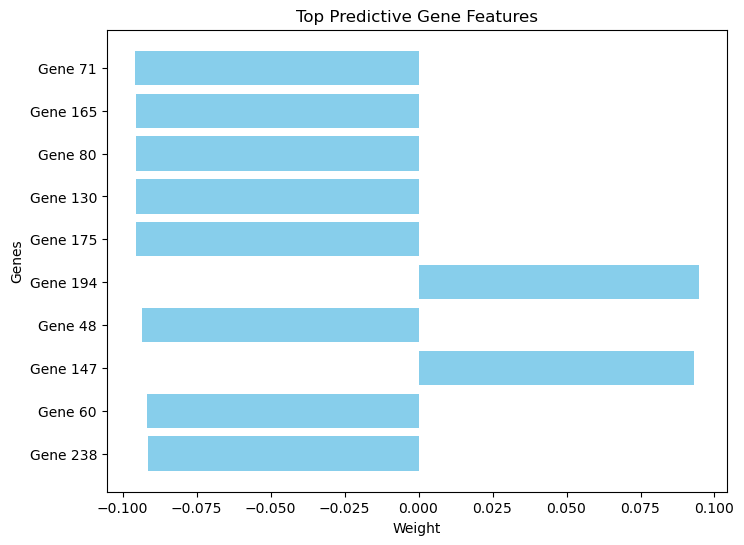

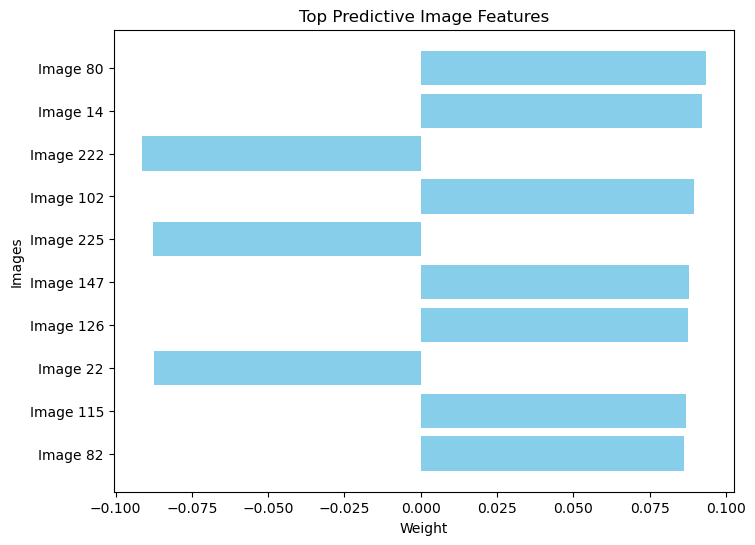

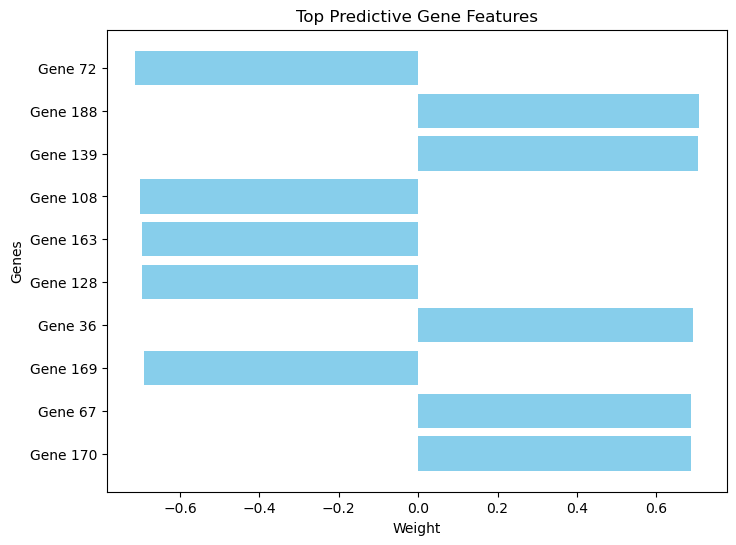

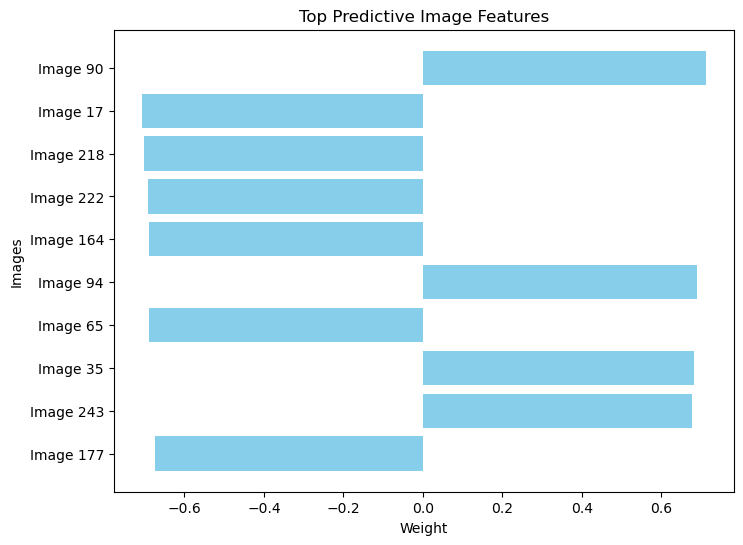

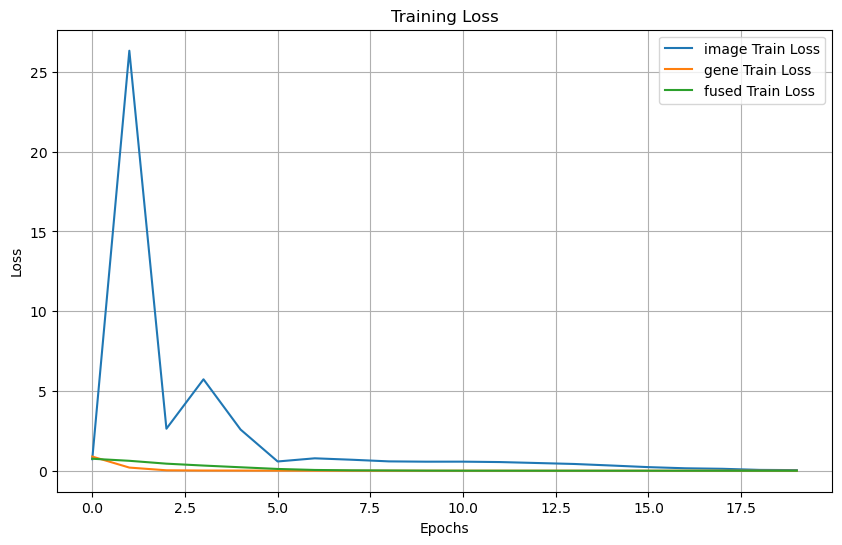

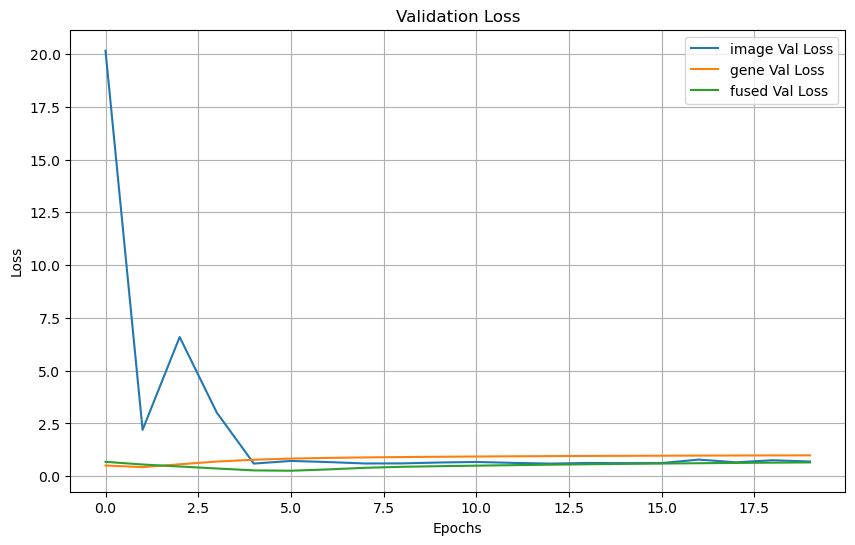

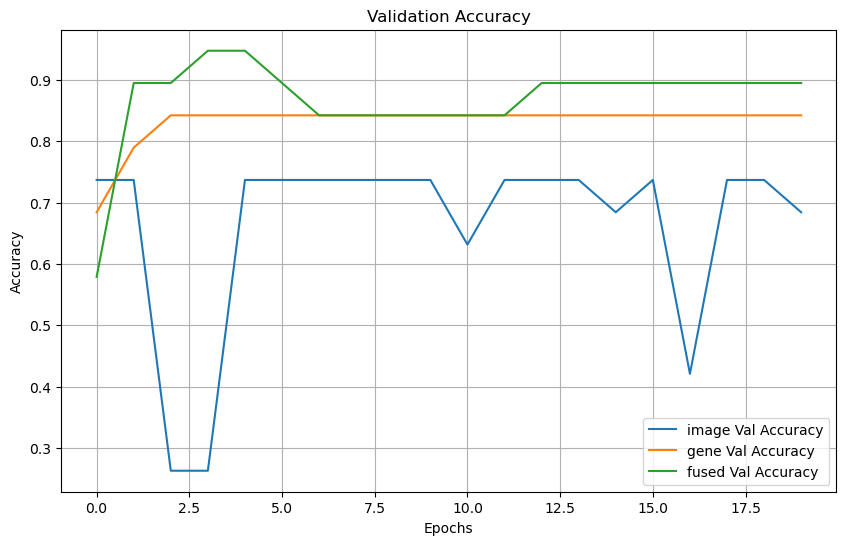

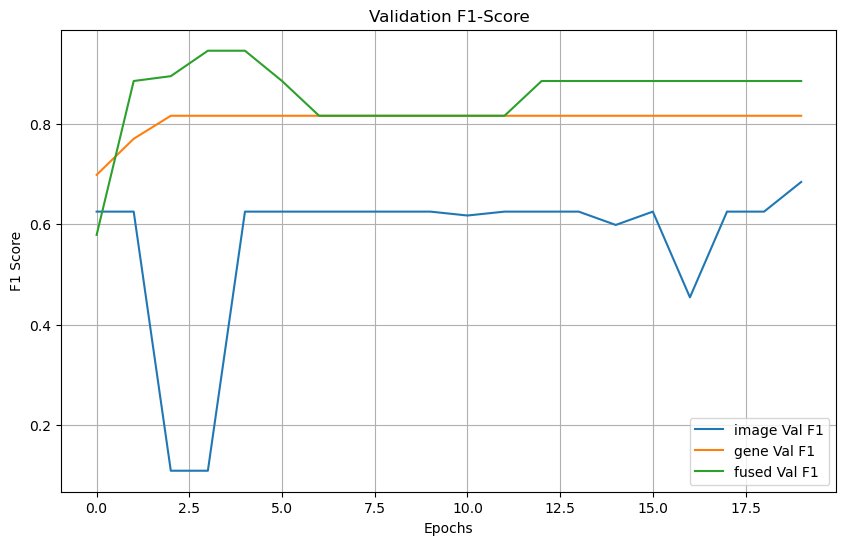

In [39]:
import numpy as np
import matplotlib.pyplot as plt

gene_weights = geneexpr_model.fc3.weight.data.cpu().numpy().flatten()
top_indices = np.argsort(np.abs(gene_weights))[-10:][::-1]
top_genes = [f"Gene {i}" for i in top_indices]  
top_weights = gene_weights[top_indices]

plt.figure(figsize=(8, 6))
plt.barh(top_genes, top_weights, color='skyblue')
plt.xlabel('Weight')
plt.ylabel('Genes')
plt.title('Top Predictive Gene Features')
plt.gca().invert_yaxis()
plt.show()

image_weights = image_model.fc3.weight.data.cpu().numpy().flatten()
top_indices = np.argsort(np.abs(image_weights))[-10:][::-1]
top_images = [f"Image {i}" for i in top_indices]  
top_weights = image_weights[top_indices]

plt.figure(figsize=(8, 6))
plt.barh(top_images, top_weights, color='skyblue')
plt.xlabel('Weight')
plt.ylabel('Images')
plt.title('Top Predictive Image Features')
plt.gca().invert_yaxis()
plt.show()

gene_weights = fusion_model.gene_fc.weight.data.cpu().numpy().flatten()
top_indices = np.argsort(np.abs(gene_weights))[-10:][::-1]
top_genes = [f"Gene {i}" for i in top_indices]  
top_weights = gene_weights[top_indices]

plt.figure(figsize=(8, 6))
plt.barh(top_genes, top_weights, color='skyblue')
plt.xlabel('Weight')
plt.ylabel('Genes')
plt.title('Top Predictive Gene Features')
plt.gca().invert_yaxis()
plt.show()

image_weights = fusion_model.image_fc.weight.data.cpu().numpy().flatten()
top_indices = np.argsort(np.abs(image_weights))[-10:][::-1]
top_images = [f"Image {i}" for i in top_indices] 
top_weights = image_weights[top_indices]

plt.figure(figsize=(8, 6))
plt.barh(top_images, top_weights, color='skyblue')
plt.xlabel('Weight')
plt.ylabel('Images')
plt.title('Top Predictive Image Features')
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(10, 6))
for modality in ['image', 'gene', 'fused']:
    plt.plot(metrics[modality]['train_loss'], label=f'{modality} Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
for modality in ['image', 'gene', 'fused']:
    plt.plot(metrics[modality]['val_loss'], label=f'{modality} Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
for modality in ['image', 'gene', 'fused']:
    plt.plot(metrics[modality]['val_accuracy'], label=f'{modality} Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
for modality in ['image', 'gene', 'fused']:
    plt.plot(metrics[modality]['val_f1'], label=f'{modality} Val F1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Validation F1-Score')
plt.legend()
plt.grid()
plt.show()